`imports`

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.datasets as datasets
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import random
from collections import defaultdict
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

`load data`

In [31]:
# Define transforms (resize + convert to tensor)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Omniglot is grayscale
    transforms.Resize((28, 28)),  # Resize to 28x28
    transforms.ToTensor()
])

# Download Omniglot (background = training, evaluation = testing)
train_dataset = datasets.Omniglot(root="./data", background=True, download=True, transform=transform)
test_dataset = datasets.Omniglot(root="./data", background=False, download=True, transform=transform)

print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))


Train size: 19280
Test size: 13180


`create episode`

In [32]:
class EpisodeDataset(Dataset):
    def __init__(self, dataset, n_classes=5, n_support=5, n_query=2, episodes_per_epoch=100):
        self.dataset = dataset
        self.n_classes = n_classes
        self.n_support = n_support
        self.n_query = n_query
        self.episodes_per_epoch = episodes_per_epoch

        # Group indices by class
        self.class_to_indices = defaultdict(list)
        for idx, (_, label) in enumerate(dataset):
            self.class_to_indices[label].append(idx)

        self.classes = list(self.class_to_indices.keys())

    def __len__(self):
        return self.episodes_per_epoch

    def __getitem__(self, idx):

        selected_classes = random.sample(self.classes, self.n_classes)

        support_images, support_labels = [], []
        query_images, query_labels = [], []

        for label_idx, cls in enumerate(selected_classes):
            indices = random.sample(self.class_to_indices[cls], self.n_support + self.n_query)
            support_indices = indices[:self.n_support]
            query_indices = indices[self.n_support:]

            # Collect support samples
            for i in support_indices:
                img, _ = self.dataset[i]
                support_images.append(img)
                support_labels.append(label_idx)  # re-map labels 0..N-1

            # Collect query samples
            for i in query_indices:
                img, _ = self.dataset[i]
                query_images.append(img)
                query_labels.append(label_idx)

        # Convert to tensors
        support_images = torch.stack(support_images)  # [N_support * N_classes, Channels, H, W]
        support_labels = torch.tensor(support_labels)

        query_images = torch.stack(query_images)      # [N_query * N_classes, Channels, H, W]
        query_labels = torch.tensor(query_labels)

        return support_images, support_labels, query_images, query_labels


In [33]:
# Create episode dataset and dataloader
episode_dataset = EpisodeDataset(train_dataset, n_classes=5, n_support=5, n_query=2, episodes_per_epoch=100)
episode_loader = DataLoader(episode_dataset, batch_size=1, shuffle=False)

# Get 1 episode
support_imgs, support_lbls, query_imgs, query_lbls = next(iter(episode_loader))

print("Support set:", support_imgs.shape, support_lbls.shape)
print("Query set:", query_imgs.shape, query_lbls.shape)

Support set: torch.Size([1, 25, 1, 28, 28]) torch.Size([1, 25])
Query set: torch.Size([1, 10, 1, 28, 28]) torch.Size([1, 10])


`model defiantion(CNN)`

In [34]:
class ProtoNetEncoder(nn.Module):
    def __init__(self, hidden_size=64):
        super().__init__()
        self.encoder = nn.Sequential(

            nn.Conv2d(in_channels=1, out_channels=hidden_size, kernel_size=3, stride=1),
            nn.BatchNorm2d(num_features=hidden_size),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 → 14x14

            nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3, stride=1),
            nn.BatchNorm2d(num_features=hidden_size),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1),  # 14x14 → 12x12

            nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3, stride=1),
            nn.BatchNorm2d(num_features=hidden_size),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1),  # 12x12 → 10x10

            nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3, stride=1),
            nn.BatchNorm2d(num_features=hidden_size),
            nn.ReLU(inplace=True),

            # Global pooling
            nn.AdaptiveAvgPool2d(output_size=(1, 1))  # shrink to [batch, hidden_size, 1, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # flatten → [batch, hidden_size] (final embedding vector)
        return x
    

In [35]:
# compute k vectors for each class and average them
def compute_prototypes(embeddings, labels):
    prototypes = []
    for cls in torch.unique(labels):
        cls_embeddings = embeddings[labels == cls]
        proto = cls_embeddings.mean(dim=0)
        prototypes.append(proto)
    return torch.stack(prototypes)

In [36]:
# compute distance between each query and prototypes
def euclidean_dist(a, b):
    # a: [n_query, d], b: [n_classes, d]
    n, m, d = a.size(0), b.size(0), a.size(1)
    a = a.unsqueeze(1).expand(n, m, d)
    b = b.unsqueeze(0).expand(n, m, d)
    return torch.pow(a - b, 2).sum(2)  # [n_query, n_classes]

In [37]:
# predict query labels based on nearest prototype
def predict(query_embeddings, prototypes):
    dists = euclidean_dist(query_embeddings, prototypes)  # [n_query, n_classes]
    return torch.argmin(dists, dim=1)  # pick nearest prototype

In [38]:
# cross-entropy loss between predicted and true labels
def prototypical_loss(query_embeddings, query_labels, prototypes):
    dists = euclidean_dist(query_embeddings, prototypes)  # [n_query, n_classes]
    # negative distances → log_softmax → cross entropy
    log_p_y = torch.log_softmax(-dists, dim=1)  
    loss = F.nll_loss(log_p_y, query_labels)
    _, y_hat = log_p_y.max(1)
    acc = torch.eq(y_hat, query_labels).float().mean().item()
    return loss, acc

`training`

In [39]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = ProtoNetEncoder().to(device)
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)

for epoch in range(10):
    total_loss, total_acc = 0, 0
    for support_imgs, support_lbls, query_imgs, query_lbls in episode_loader:
        support_imgs, support_lbls = support_imgs.squeeze(0).to(device), support_lbls.squeeze(0).to(device)
        query_imgs, query_lbls = query_imgs.squeeze(0).to(device), query_lbls.squeeze(0).to(device)

        optimizer.zero_grad()

        # Encode
        support_embeddings = encoder(support_imgs)
        query_embeddings = encoder(query_imgs)

        # Prototypes
        prototypes = compute_prototypes(support_embeddings, support_lbls)

        # Loss
        loss, acc = prototypical_loss(query_embeddings, query_lbls, prototypes)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += acc

    print(f"Epoch {epoch+1}: Loss = {total_loss/len(episode_loader):.4f}, "
          f"Acc = {total_acc/len(episode_loader):.4f}")


Epoch 1: Loss = 0.2729, Acc = 0.9210
Epoch 2: Loss = 0.2276, Acc = 0.9290
Epoch 3: Loss = 0.1698, Acc = 0.9350
Epoch 4: Loss = 0.1647, Acc = 0.9490
Epoch 5: Loss = 0.1613, Acc = 0.9470
Epoch 6: Loss = 0.0989, Acc = 0.9700
Epoch 7: Loss = 0.1170, Acc = 0.9680
Epoch 8: Loss = 0.0964, Acc = 0.9720
Epoch 9: Loss = 0.0990, Acc = 0.9660
Epoch 10: Loss = 0.1204, Acc = 0.9590


`result visualizations`

In [40]:
import matplotlib.pyplot as plt

# Get one episode from loader
support_imgs, support_lbls, query_imgs, query_lbls = next(iter(episode_loader))
support_imgs, support_lbls = support_imgs.squeeze(0).to(device), support_lbls.squeeze(0).to(device)
query_imgs, query_lbls = query_imgs.squeeze(0).to(device), query_lbls.squeeze(0).to(device)

# Encode
with torch.no_grad():
    support_embeddings = encoder(support_imgs)
    query_embeddings = encoder(query_imgs)
    prototypes = compute_prototypes(support_embeddings, support_lbls)
    preds = predict(query_embeddings, prototypes)


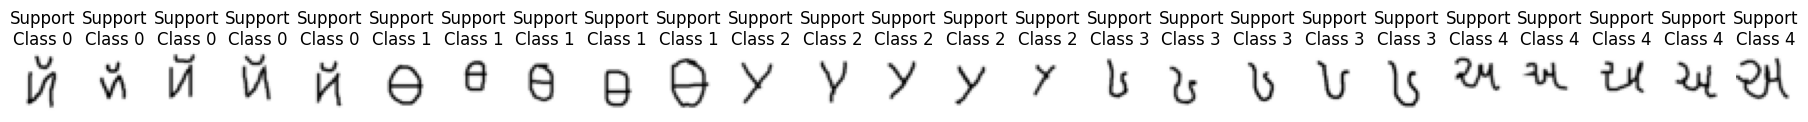

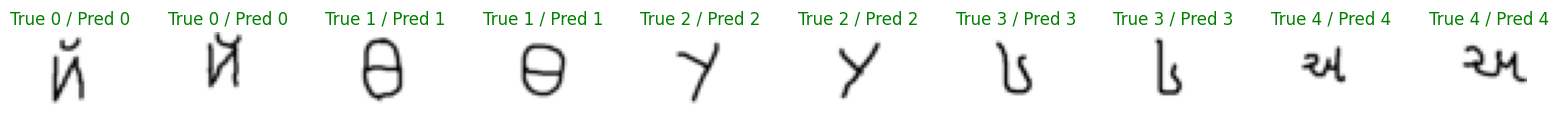

In [41]:
def plot_episode(support_imgs, support_lbls, query_imgs, query_lbls, preds):
    # Support row
    fig, axes = plt.subplots(1, len(support_imgs), figsize=(23, 8))
    for i, (img, lbl) in enumerate(zip(support_imgs, support_lbls)):
        axes[i].imshow(img.cpu().squeeze(), cmap="gray")
        axes[i].set_title(f"Support\nClass {lbl.item()}")
        axes[i].axis("off")
    plt.show()

    # Query row
    fig, axes = plt.subplots(1, len(query_imgs), figsize=(20, 1))
    for i, (img, lbl, pred) in enumerate(zip(query_imgs, query_lbls, preds)):
        color = "green" if lbl.item() == pred.item() else "red"
        axes[i].imshow(img.cpu().squeeze(), cmap="gray")
        axes[i].set_title(f"True {lbl.item()} / Pred {pred.item()}", color=color)
        axes[i].axis("off")
    plt.show()

plot_episode(support_imgs, support_lbls, query_imgs, query_lbls, preds)


`evaluation`
- no more training

In [42]:
val_episode_dataset = EpisodeDataset(
    test_dataset, 
    n_classes=5, 
    n_support=5, 
    n_query=2, 
    episodes_per_epoch=100
)

val_episode_loader = DataLoader(val_episode_dataset, batch_size=1, shuffle=False)


In [43]:
def evaluate(encoder, episode_loader, device):
    encoder.eval()
    total_loss, total_acc = 0, 0

    with torch.no_grad():
        for support_imgs, support_lbls, query_imgs, query_lbls in episode_loader:
            support_imgs, support_lbls = support_imgs.squeeze(0).to(device), support_lbls.squeeze(0).to(device)
            query_imgs, query_lbls = query_imgs.squeeze(0).to(device), query_lbls.squeeze(0).to(device)

            # Encode
            support_embeddings = encoder(support_imgs)
            query_embeddings = encoder(query_imgs)

            # Prototypes
            prototypes = compute_prototypes(support_embeddings, support_lbls)

            # Loss + Accuracy
            loss, acc = prototypical_loss(query_embeddings, query_lbls, prototypes)
            total_loss += loss.item()
            total_acc += acc

    return total_loss / len(episode_loader), total_acc / len(episode_loader)


`visualization`

In [44]:
def evaluate_and_visualize(encoder, episode_loader, device, n_visualize=3):
    encoder.eval()
    total_loss, total_acc = 0, 0

    with torch.no_grad():
        for i, (support_imgs, support_lbls, query_imgs, query_lbls) in enumerate(episode_loader):
            support_imgs, support_lbls = support_imgs.squeeze(0).to(device), support_lbls.squeeze(0).to(device)
            query_imgs, query_lbls = query_imgs.squeeze(0).to(device), query_lbls.squeeze(0).to(device)

            # Encode
            support_embeddings = encoder(support_imgs)
            query_embeddings = encoder(query_imgs)

            # Prototypes
            prototypes = compute_prototypes(support_embeddings, support_lbls)

            # Loss + Accuracy
            loss, acc = prototypical_loss(query_embeddings, query_lbls, prototypes)
            total_loss += loss.item()
            total_acc += acc

            # Predictions
            preds = predict(query_embeddings, prototypes)

            # ---- Visualization ----
            if i < n_visualize:
                plot_episode(support_imgs, support_lbls, query_imgs, query_lbls, preds)

    return total_loss / len(episode_loader), total_acc / len(episode_loader)


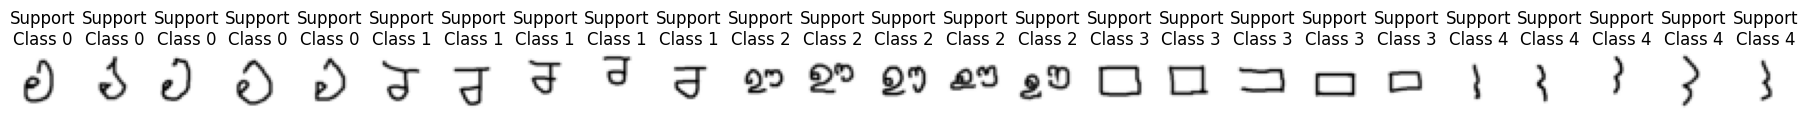

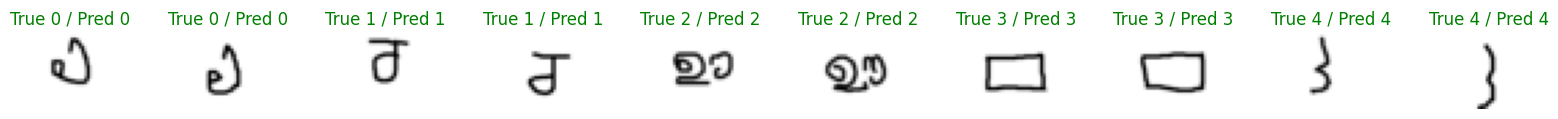

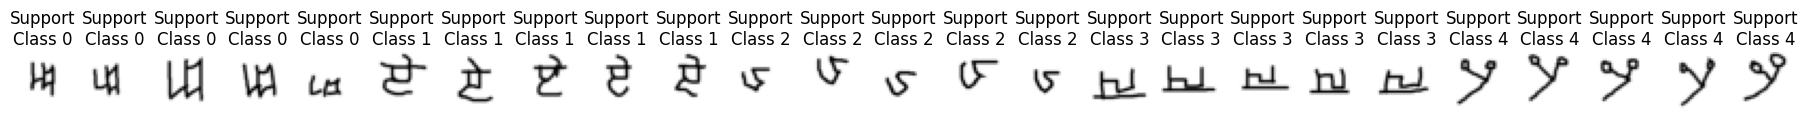

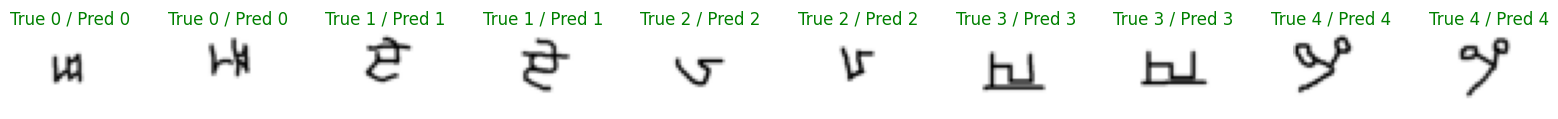

Validation: Loss = 0.2209, Acc = 0.9330


In [51]:
val_loss, val_acc = evaluate_and_visualize(encoder, val_episode_loader, device, n_visualize=2)
print(f"Validation: Loss = {val_loss:.4f}, Acc = {val_acc:.4f}")

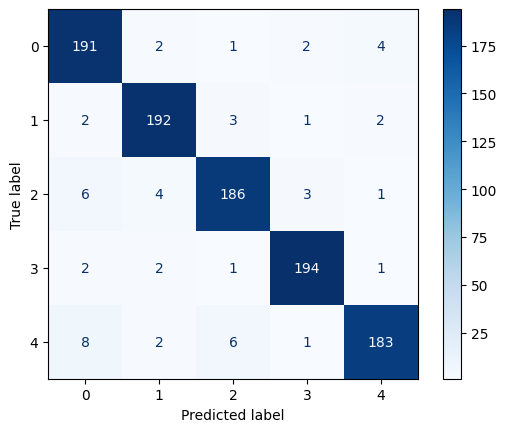

In [52]:
y_true, y_pred = [], []

with torch.no_grad():
    for support_imgs, support_lbls, query_imgs, query_lbls in val_episode_loader:
        support_imgs, support_lbls = support_imgs.squeeze(0).to(device), support_lbls.squeeze(0).to(device)
        query_imgs, query_lbls = query_imgs.squeeze(0).to(device), query_lbls.squeeze(0).to(device)

        support_embeddings = encoder(support_imgs)
        query_embeddings = encoder(query_imgs)
        prototypes = compute_prototypes(support_embeddings, support_lbls)
        preds = predict(query_embeddings, prototypes)

        y_true.extend(query_lbls.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.show()
